In [0]:
#pip install spotipy
import pandas as pd 
import numpy as np
import spotipy 
import pprint
import spotipy.util as util
import statsmodels.api as sm
from spotipy.oauth2 import SpotifyClientCredentials 
from sklearn.metrics import confusion_matrix
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [0]:
#https://developer.spotify.com/console/get-current-user-top-artists-and-tracks/?type=artists&time_range=&limit=50&offset=
mytoken = ""
sp = spotipy.Spotify(auth = mytoken)

# Lets get 50 albums that I have downloaded to start building my dataset
myalbums = sp.current_user_saved_albums(limit=50)
album_tracks = []
for album in myalbums["items"]:
  rdate = album['album']['release_date']
  album_artist = album["album"]["artists"][0]["name"]
  for song in album["album"]["tracks"]["items"]:
      songdict = {}
      songdict["id"] = song["id"]
      songdict["artist_name"] = album_artist
      songdict["song_name"] = song["name"]
      songdict["rdate"] = rdate
      album_tracks.append(songdict)

In [0]:
# I picked out some others that are old to balance out our classes
hand_picked_albums = [
    "468ZwCchVtzEbt9BHmXopb"
,"1lZahjeu4AhPkg9JARZr5F"
,"58MQ0PLijVHePUonQlK76Y"
,"21KIagsx1ZvYcv0sVkEAWv"
,"3w5Hok05AFjCLy269xXM7e"
,"4eTVgxB6wm5eGvesA4cUN5"
,"4Gh6pRaXqXTtJx4plAJbBw"
,"3EbtMJsHbspjhN6Xd4plIu"
,"3KEGHqlHA1kvT9jLY9u38q"
,"4NHPuxA6jrvjJ4ZxFncIwi"
,"13dXX35pYjr8FqRla40K2a"
,"7mRHt0S0Jrc9f112wMvchh"
,"56I4vUYWQ4aXLiyfo8XuZv"
,"1kH2CE1cZ61h3XjBsyCAvB"
,"5bO76EkQUOyu0vYkF9tYq7"
,"3Eg4Laj6Pm6GwV6VF2I1Q8"
,"4PznnWq19AwatCG4lsyb5I"
,"59Wr4PvymWsp1mboCa5QLy"
,"56H0s8mDvyhVZOWn3vEBgS"
,"1kuAkkhsye50w4et6k4vOT"
,"5FWAviP7cXvH8iOVENSaNG"
,"57GMEh9tkmc1TGs4rcdVhN"
,"2QLp07RO6anZHmtcKTEvSC"
,"27u4epCdDfTiogQolAomAl"
,"7dsWupQRlFuhG8FGiQAUjC"
,"6u5tGarzvESDsQiIpC4SlI"
,"6YabPKtZAjxwyWbuO9p4ZD"
,"3q90UAYeHLvAtnowiQlmgp"
,"7AgI5vniflcbh86Znea7yM"
,"0sGBs4v8lfyIN1tqZubLgA"
,"03HMOcANauhLD0WNrMkmLU"
,"4RMGrhJRnGiNqmKqhqpLlX"
,"1jWmEhn3ggaL6isoyLfwBn"
,"6lPb7Eoon6QPbscWbMsk6a"
,"2ULhVPvdhT7RREnqRWM06G"
,"10v912xgTZbjAtYfyKWJCS"
,"4EsbzWIeUYpEF5Sv0yH8Ig"
,"6DUa06cy7WWvhba9Jiheyg"
,"7y2gHGuQhJmesRiNO8d8fK"
,"1OvmilWKtrabJGEpPRlgK5"
,"0cw6Sv7IwZ87aLPPvNPSd0"
,"2NFd4ApYFitFtJhGTSfDdP"
,"6N8uPmDqbgXD3ztkCCfxoo"
,"4ZCrk8P8S1iSsEXZjimtPY"
,"40aG9ahuLnAv96yoFG75Uy"
,"4wy9Np1Skr6jQ46nrbFQ8L"
,"3Cfxn2VpzchoMTJ5b362L6"
,"29m6DinzdaD0OPqWKGyMdz"
,"4qHWXbp5TbUWqH35c6m8kN"
,"0ky5kdvfPxSmSpj03hpSAE"
,"4SN55bwEnC0T1qmBTWZeyW"            
]

album_dicts = []
for each in hand_picked_albums:
  album_dicts.append(sp.album(each))

for album in album_dicts:
  rdate = album['release_date']
  album_artist = album["artists"][0]["name"]
  for song in album["tracks"]["items"]:
      songdict = {}
      songdict["id"] = song["id"]
      songdict["artist_name"] = album_artist
      songdict["song_name"] = song["name"]
      songdict["rdate"] = rdate
      album_tracks.append(songdict)
myalbum_data = pd.DataFrame(album_tracks)

In [167]:
 # Now we utilize the API to get more advanced song features
 song_feature_list = []
 for songid in myalbum_data["id"]: 
  feat_dict = sp.audio_features(songid)[0]
  feat_dict["id"] = songid
  song_feature_list.append(feat_dict)
features = pd.DataFrame(song_feature_list)

retrying ...4secs
retrying ...5secs
retrying ...5secs
retrying ...3secs
retrying ...2secs
retrying ...5secs
retrying ...1secs
retrying ...4secs
retrying ...5secs


In [0]:
#Put it all together, and define an "old" song
song_model_data = myalbum_data.merge(features, how = 'inner', on = 'id')
song_model_data["ryear"] = song_model_data.rdate.str.extract(r"(\d\d\d\d)").astype(int)
song_model_data["is_old"] = np.where(song_model_data["ryear"] < 1980, 1, 0)

acousticness


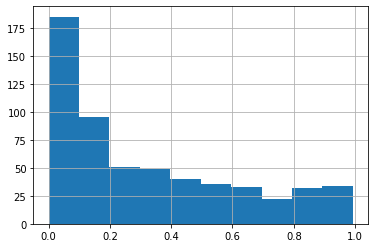

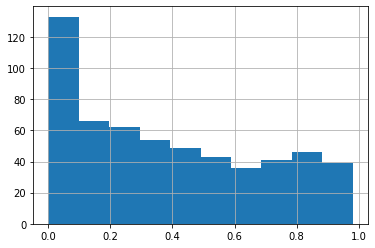

danceability


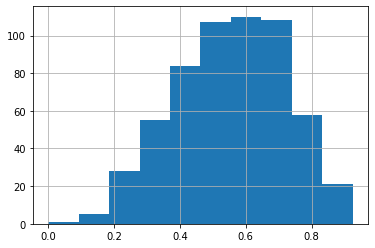

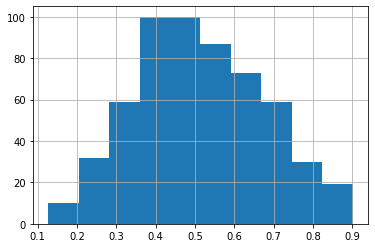

duration_ms


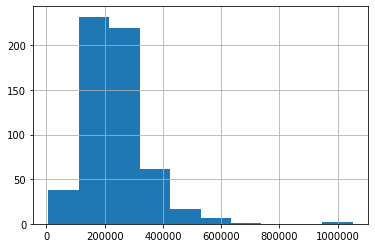

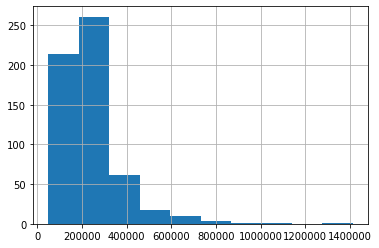

In [169]:
# Before we build our model, let's do some EDA
newsongs = song_model_data[song_model_data.is_old == 0]
oldsongs = song_model_data[song_model_data.is_old == 1]

#Lets see if some variables look to be different between our classes

#We expect older songs to be more acoustic (lets audio engineering, more guitar work)
print("acousticness")
newsongs.acousticness.hist()
plt.show()
oldsongs.acousticness.hist()
plt.show()
#Looks like this is happening!

#We expect older songs to be less dancable, more irregular compositions
print("danceability")
newsongs.danceability.hist()
plt.show()
oldsongs.danceability.hist()
plt.show()
#Looks like this is happening!

#We expect older songs to be longer (i/e extended jams present)
print("duration_ms")
newsongs.duration_ms.hist()
plt.show()
oldsongs.duration_ms.hist()
plt.show()
#Less clear

In [177]:
# Before I build my predictive model, let's do some inference to see what features could be helpful
# Logistic regression here we come
logit_X = song_model_data.copy()[["danceability", "energy", "loudness", "mode", "acousticness", "valence", "tempo", "duration_ms"]]
logit_X["intercept"] = 1
logit_y = song_model_data.is_old
logit = sm.Logit(logit_y, logit_X)
logit.fit().summary()
#interestingly, most variables look like they help, except acousticness and tempo

Optimization terminated successfully.
         Current function value: 0.546252
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 is_old   No. Observations:                 1146
Model:                          Logit   Df Residuals:                     1137
Method:                           MLE   Df Model:                            8
Date:                Mon, 09 Mar 2020   Pseudo R-squ.:                  0.2119
Time:                        03:08:44   Log-Likelihood:                -626.00
converged:                       True   LL-Null:                       -794.32
Covariance Type:            nonrobust   LLR p-value:                 6.456e-68
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
danceability    -4.2257      0.527     -8.024      0.000      -5.258      -3.194
energy          -1.5428      0.602     -2.561      0.010      -2.723      -0.362
loudness        -0.1501      0.028     -5.278      0.000      -0.206      -0.094
mode             0.7926      0.150      5.298      0.000       0.499       1.086
acousticness     0.2381      0.296      0.805      0.421      -0.342       0.818
valence          5.1302      0.422     12.152      0.000       4.303       5.958
tempo        -5.962e-05      0.002     -0.026      0.979      -0.005       0.004
duration_ms   2.705e-06   6.76e-07      4.003      0.000    1.38e-06    4.03e-06
intercept       -2.3931      0.764     -3.134      0.002      -3.890      -0.897
================================================================================
"""

In [171]:
# Ok with this knowledge, lets train a boosted classifer using all variables.
# The decision trees themselves should sort out which variables to use :)
# First we split the data in test and train

X_df = song_model_data[["danceability", "energy", "loudness", "mode", "acousticness", "valence", "tempo", "duration_ms"]]
y_array = song_model_data["is_old"]

xtrain, xtest, ytrain, ytest = train_test_split(X_df, y_array, test_size = 0.2, random_state = 0)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, test_size = .2, random_state = 0)

# Lets take a look at some valuation errors to get best model performance, changed max_depth for better performance

boosted_model =xgb.XGBClassifier(random_state=1,learning_rate=0.01, max_depth = 10)
boosted_model.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [172]:
# We expect training error to be higher, which it is :)
print("Training accuracy:   {}".format(boosted_model.score(xtrain, ytrain)))
print("Test accuracy:       {}".format(boosted_model.score(xtest, ytest)))

Training accuracy:   0.9672131147540983
Test accuracy:       0.7565217391304347


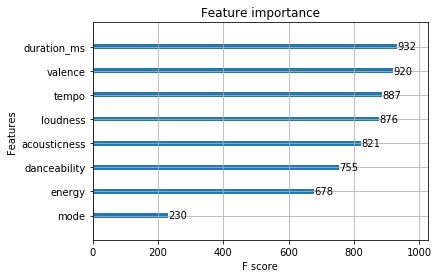

In [173]:
# Lets check out feature importance, and compare to our logit model
plot_importance(boosted_model)
#Similar, but not the exact same. Looks like major vs minor key really doesnt help

In [174]:
# Lets see overall performance with a confusion matrix
tn, fp, fn, tp = confusion_matrix(ytest,boosted_model.predict(xtest)).ravel()
#Recall is how many we correctly said were old, divided by all truly old songs
#Precision is how many we correcly said were old, divided by how many we said were old
print("recall is    {}".format(tp / (tp + fn)))
print("precision is {}".format(tp / (tp + fp)))
# Were doing a great job!

recall is    0.7777777777777778
precision is 0.8015267175572519


In [175]:
# Lastly, lets check on our guy Leon, and see if our algorithm can tell hes making music today and not back in the day!
# And lets compare him to Sam Cooke, a big influence of his, who made music in the 60's
xtest_qa = xtest.copy()
xtest_qa["predicted_is_old"] = boosted_model.predict(xtest)
xtest_qa["is_old"] = ytest
xtest_w_songs = xtest_qa.merge(song_model_data[["artist_name", "song_name"]], right_index=True, left_index=True)
xtest_w_songs["counter"] = 1

test_by_artist = xtest_w_songs.groupby("artist_name", as_index=False)[["predicted_is_old", "is_old", "counter"]].sum().rename(columns = {'counter': "total_songs"})
test_by_artist[test_by_artist.artist_name.isin(["Leon Bridges", "Sam Cooke"])]
# Nice! Our algorithm predicted both of Sam Cooke's songs were old, but only 1 of 6 of Leon's songs.
# Now that's a smart algorithm :)

,artist_name,predicted_is_old,is_old,total_songs
43,Leon Bridges,1,0,6
65,Sam Cooke,2,2,2
